In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import os
import datetime

import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.metrics import accuracy_score

%load_ext tensorboard

In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign"

In [3]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [4]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [5]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [6]:
model = Sequential([
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                     
                    Flatten(),
                    Dense(num_classes, activation='softmax')
 ])

#  model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 7s 7ms/step - loss: 15.2951 - accuracy: 0.7713


In [7]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                     
                    Flatten(),
                    Dense(num_classes, activation='softmax')
 ])

def train_model(model, X_train, y_train, params_fit={}):
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    model.fit(
        X_train, 
        y_train,
        batch_size=params_fit.get('batch_size', 128),
        epochs=params_fit.get('epochs', 5),
        verbose=params_fit.get('verbose', 1),
        validation_data=params_fit.get('validation_data', (X_train, y_train)),
        callbacks= [tensorboard_callback]
    )

    return model

In [8]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 36.9101 - accuracy: 0.7252 - val_loss: 0.2703 - val_accuracy: 0.9394
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2317 - accuracy: 0.9448 - val_loss: 0.1308 - val_accuracy: 0.9714
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1332 - accuracy: 0.9683 - val_loss: 0.1057 - val_accuracy: 0.9766
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1286 - accuracy: 0.9695 - val_loss: 0.0803 - val_accuracy: 0.9790
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0990 - accuracy: 0.9759 - val_loss: 0.0892 - val_accuracy: 0.9804


In [9]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [10]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  

  return accuracy_score(y_test_norm, y_pred)


In [11]:
predict(model_trained, X_test, y_test)

0.8133786848072563

In [16]:
def train_and_predict(model): 
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [15]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                    MaxPool2D(),
                    Dropout(0.3),

                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),

                    Flatten(),
                     
                    Dense(1024, activation='relu'),
                    Dropout(0.3),

                    Dense(num_classes, activation='softmax'),
 ])

train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 6.9383 - accuracy: 0.2435 - val_loss: 1.6862 - val_accuracy: 0.5279
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 1.3726 - accuracy: 0.5941 - val_loss: 0.5149 - val_accuracy: 0.8837
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.7026 - accuracy: 0.7915 - val_loss: 0.2186 - val_accuracy: 0.9522
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.4613 - accuracy: 0.8610 - val_loss: 0.1151 - val_accuracy: 0.9749
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.3495 - accuracy: 0.8949 - val_loss: 0.0842 - val_accuracy: 0.9799


0.9056689342403628

<BarContainer object of 43 artists>

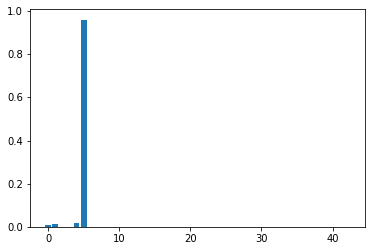

In [ ]:
plt.bar(range(43), y_pred_prob[400])

In [ ]:
labels_dict[ np.argmax( y_pred_prob[400] ) ]

'Speed limit (80km/h)'

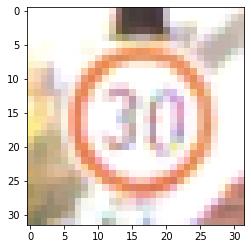

In [ ]:
plt.imshow(X_test[400])

In [19]:
def get_ccn_v3(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])


train_and_predict( get_ccn_v3(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 10s 38ms/step - loss: 2.3405 - accuracy: 0.4840 - val_loss: 0.2577 - val_accuracy: 0.9401
Epoch 2/5
272/272 [==============================] - 10s 36ms/step - loss: 0.4531 - accuracy: 0.8736 - val_loss: 0.0842 - val_accuracy: 0.9807
Epoch 3/5
272/272 [==============================] - 10s 36ms/step - loss: 0.2523 - accuracy: 0.9273 - val_loss: 0.0479 - val_accuracy: 0.9909
Epoch 4/5
272/272 [==============================] - 10s 36ms/step - loss: 0.1702 - accuracy: 0.9499 - val_loss: 0.0334 - val_accuracy: 0.9922
Epoch 5/5
272/272 [==============================] - 10s 36ms/step - loss: 0.1359 - accuracy: 0.9603 - val_loss: 0.0153 - val_accuracy: 0.9972


0.9659863945578231

In [18]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),

                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),

                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    # Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    MaxPool2D(),
                    Dropout(0.3),

                    Flatten(),
                     
                    Dense(1024, activation='relu'),
                    Dropout(0.3),

                    Dense(num_classes, activation='softmax'),
 ])

get_cnn_v4(input_shape, num_classes).summary()

# train_and_predict(get_cnn_v3(input_shape, num_classes))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)         

In [21]:
def get_ccn_v5(input_shape, num_classes):
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape ),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(num_classes, activation = 'softmax'),
    ])

train_and_predict( get_ccn_v5(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 13s 48ms/step - loss: 2.6714 - accuracy: 0.2583 - val_loss: 1.2201 - val_accuracy: 0.6189
Epoch 2/5
272/272 [==============================] - 12s 46ms/step - loss: 0.8451 - accuracy: 0.7281 - val_loss: 0.2228 - val_accuracy: 0.9317
Epoch 3/5
272/272 [==============================] - 12s 46ms/step - loss: 0.3769 - accuracy: 0.8807 - val_loss: 0.0760 - val_accuracy: 0.9798
Epoch 4/5
272/272 [==============================] - 12s 46ms/step - loss: 0.2352 - accuracy: 0.9304 - val_loss: 0.0428 - val_accuracy: 0.9876
Epoch 5/5
272/272 [==============================] - 12s 46ms/step - loss: 0.1885 - accuracy: 0.9438 - val_loss: 0.0379 - val_accuracy: 0.9886


0.9689342403628118

In [22]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [23]:
model = get_ccn_v5((32, 32, 1), num_classes)
model_trained =  train_model(model, X_train_gray, y_train, params_fit = {})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 13s 47ms/step - loss: 2.6209 - accuracy: 0.2677 - val_loss: 0.7045 - val_accuracy: 0.7708
Epoch 2/5
272/272 [==============================] - 12s 46ms/step - loss: 0.5953 - accuracy: 0.8053 - val_loss: 0.1541 - val_accuracy: 0.9483
Epoch 3/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2784 - accuracy: 0.9096 - val_loss: 0.0706 - val_accuracy: 0.9786
Epoch 4/5
272/272 [==============================] - 12s 46ms/step - loss: 0.1778 - accuracy: 0.9429 - val_loss: 0.0471 - val_accuracy: 0.9870
Epoch 5/5
272/272 [==============================] - 12s 46ms/step - loss: 0.1356 - accuracy: 0.9572 - val_loss: 0.0321 - val_accuracy: 0.9911


0.9628117913832199

In [ ]:
plt.imshow( color.rgb2gray(X_train[0]), cmap = plt.get_cmap('gray') )